# Quantifiying synchrony across subjects' keypresses
# 10/27/20

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
from scipy.stats import entropy
from sklearn import datasets, linear_model
from scipy import stats
import random
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/segment/usable_data'
data_dict = pickle.load( open( filename, "rb" ) )
filename_sums = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/segment/sums_usable_data'
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

316

### ii. import story files
#### a. import story files

In [3]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/fMRI experiment/1:8:2020_edited_stories'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

#### b. organize putative event boundaries

In [4]:
#mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = int(dfs_stories[s]['story'].iloc[0])
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [5]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [6]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [7]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [8]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

# IV. Jaccard Analysis
## A. Creating partipant x sentence array for each story 
## -organized with No Prime participants first, followed by, Location Primed, and then Social Primed

In [9]:
keypress_array = {}
summary_vals = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    n_none, y = none.shape
    print('none', none)
    loc = loc_keys[key].T
    n_loc, y = none.shape
    soc = soc_keys[key].T
    n_soc, y = none.shape
    # Concatening keypresses
    final = np.concatenate((none,loc,soc), axis = 0)
    # Putting the final array in a dictionary
    keypress_array[key] = final
    # Putting summary vals together
    summary_vals[key] = np.array([n_none, n_loc, n_soc])

none [[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 1 0 0]
 [0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 1 0 0]
 [1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0
  1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0
  0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1
  0 0 0 0]
 [1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
  1 0 0 0]]
none [[0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0]
 [1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0

## B. Jaccard Analysis creating participant x participant matrix

In [10]:
jc_array = {}

for key in keypress_array:
    n, y  = keypress_array[key].shape
    this_array = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            this_score = jaccard_score(keypress_array[key][i], keypress_array[key][j])
            this_array[i,j] = this_score
    jc_array[key] = this_array

## C. Put the jaccard indices between all people in an array, and plot the distribution of values in this array

(24, 24)
(276,)


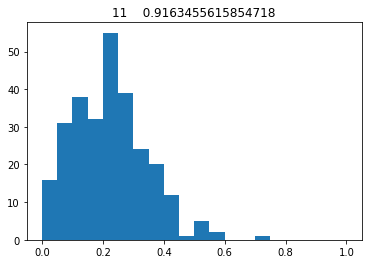

(24, 24)
(276,)


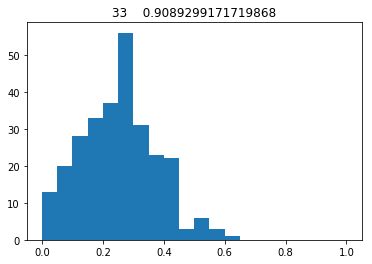

(18, 18)
(153,)


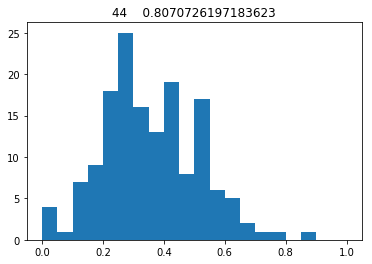

(21, 21)
(210,)


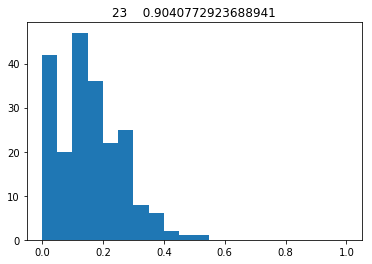

(19, 19)
(171,)


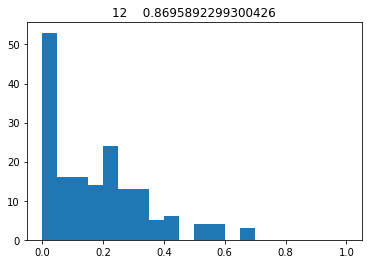

(19, 19)
(171,)


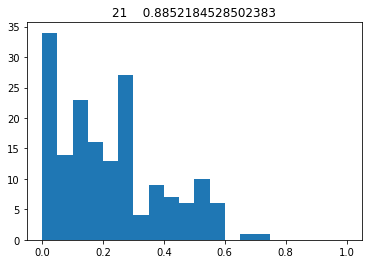

(20, 20)
(190,)


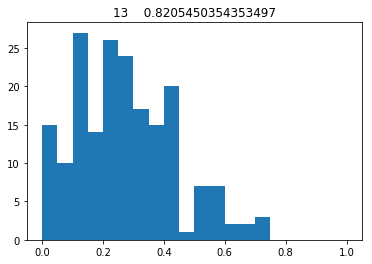

(19, 19)
(171,)


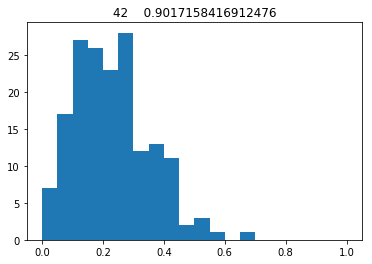

(17, 17)
(136,)


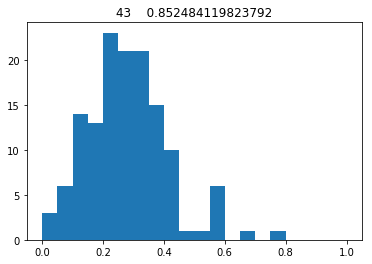

(20, 20)
(190,)


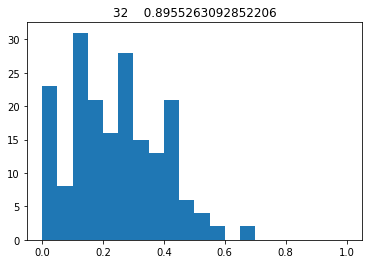

(19, 19)
(171,)


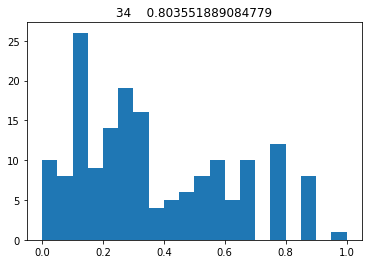

(23, 23)
(253,)


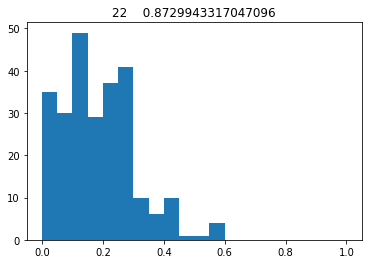

(20, 20)
(190,)


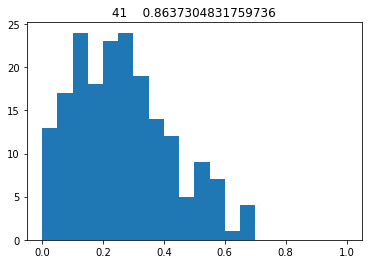

(20, 20)
(190,)


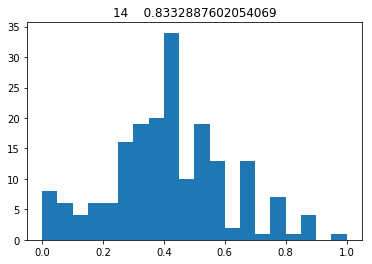

(16, 16)
(120,)


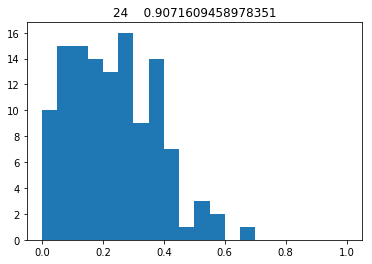

(17, 17)
(136,)


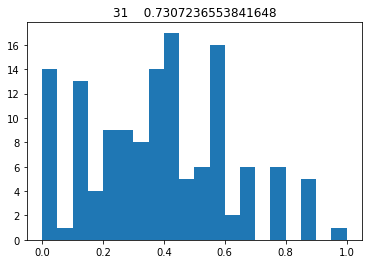

In [13]:
jc_vector = {}

for key in jc_array:
    n = jc_array[key].shape[0]
    print(jc_array[key].shape)
    this_vector = jc_array[key][np.triu_indices(n, k = 1)]
    print(this_vector.shape)
    jc_vector[key] = this_vector
    # plot a histogram of the values in the vector
    plt.hist(this_vector, bins = 20, range=[0, 1])
    plt.title(str(key) + '    ' + str(ent[key]))
    plt.show()

## D. Calculate entropy over all participants for each story

In [12]:
# Instantiating new dict and iterating through all_keys summing along row-wise
sum_keys = {}

for key in all_keys:
    these_keys = all_keys[key]
    sum_keys[key] = np.sum(these_keys, axis = 1)

  
# Plot each sum_keys array with loc boundaries
ent = {}
for key in sum_keys:
    # entropy normalizes the vector
    ent[key] = entropy(sum_keys[key])/np.log(len(story_boundaries[key]))
    
print(ent)

{11: 0.9163455615854718, 33: 0.9089299171719868, 44: 0.8070726197183623, 23: 0.9040772923688941, 12: 0.8695892299300426, 21: 0.8852184528502383, 13: 0.8205450354353497, 42: 0.9017158416912476, 43: 0.852484119823792, 32: 0.8955263092852206, 34: 0.803551889084779, 22: 0.8729943317047096, 41: 0.8637304831759736, 14: 0.8332887602054069, 24: 0.9071609458978351, 31: 0.7307236553841648}


## E. Average the values in each vector and plot against entropy

Text(0, 0.5, 'entropy')

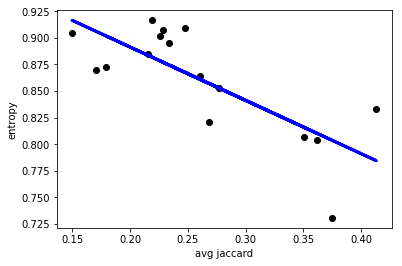

In [15]:
x = np.zeros((16))
y = np.zeros((16))

count = 0

for key in jc_vector:
    x[count] = np.mean(jc_vector[key])
    y[count] = ent[key]
    count += 1
    
# Create linear regression object
regr = linear_model.LinearRegression()

x = x.reshape(x.shape[0],-1)
y = y.reshape(y.shape[0],-1)

# Train the model using the training sets
regr.fit(x, y)

# Make predictions using the testing set
pred_y = regr.predict(x)
    
plt.plot(x, y, 'o', color='black')
plt.plot(x, pred_y, color='blue', linewidth=3)
plt.xlabel('avg jaccard')
plt.ylabel('entropy')